This notebook serves as a test to better understand zfit tools by attempting a simple gaussian fit on (1) randomized data and (2) our cryspec data

In [1]:
import uproot
import tensorflow as tf
import zfit
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math

/opt/anaconda3/envs/m2_req/lib/python3.10/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
data = zfit.Data.from_root("mu2e_caloSimu_crySpec867_TTREE.root", "specTree", ["spec", "ratio", "ntrig", "stim", "time", "tErg"])
energy_unbinned = data["spec"]

#### Parameters for all data

In [3]:
cryspec = zfit.Space(['x'], limits=(0,8)) #obs range
mu = zfit.Parameter("guess mean",5, 0,8)
sigma = zfit.Parameter("guess width", 1,0,7)
alpha = zfit.Parameter("alpha", 2.5, 0.05, 20.0);
ndeg = zfit.Parameter ("ndeg", 10, 0.25, 80.);

In [4]:
alldata = zfit.pdf.CrystalBall(obs=cryspec, mu=mu, sigma=sigma, alpha=alpha, n=ndeg)

#### Setting limits, scale, x & y axis

In [5]:
lower, upper = cryspec.limits
bin_count = 320
x_range= cryspec.area()

x_plot = np.linspace(lower[-1][0], upper[0][-1], num=len(energy_unbinned))

scale = (len(energy_unbinned)/bin_count)*x_range

y_plot_alldata = zfit.run(alldata.pdf(x_plot,norm_range=cryspec))

<zfit.Parameter 'guess mean' floating=True value=5>
<zfit.Parameter 'guess width' floating=True value=1>
<zfit.Parameter 'alpha' floating=True value=2.5>
<zfit.Parameter 'ndeg' floating=True value=10>


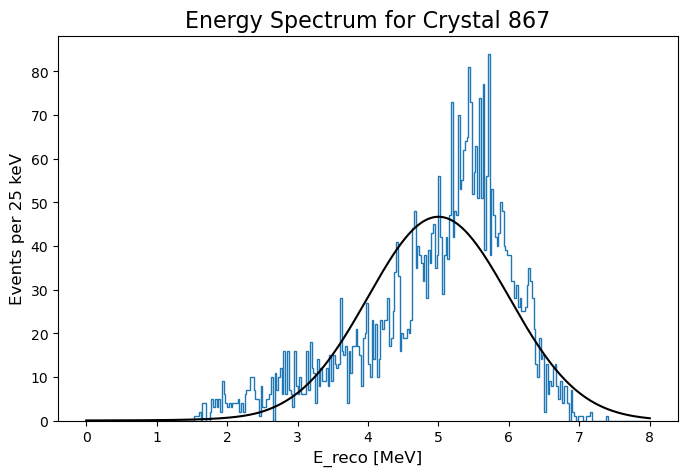

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
energy_binned, bin_location, patches = ax.hist(energy_unbinned,
                           bins=bin_count,histtype='step',
                           range=(0,8))
x_plot_binned = np.linspace(lower[-1][0], upper[0][-1], num=len(energy_binned))
y_plot_alldata_binned = zfit.run(alldata.pdf(x_plot_binned,norm_range=cryspec))

scale_binned = (np.sum(energy_binned)/bin_count)*x_range


plt.plot(x_plot, y_plot_alldata*scale, color="black", label='Full Peak CB')

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
#printing values to test what they are before and after minimisation  
print(mu)
print(sigma)
print(alpha)
print(ndeg)
# these values are evidently the ones set in the definition

#### Integral Test

In [9]:
#check to see if sum of binned data is accurate length of unbinned data
print("Sum of binned data:",np.sum(energy_binned))
print("Length of unbinned data",len(energy_unbinned))
alldata_integral = scipy.integrate.trapz(y_plot_alldata*scale)
print("Integral of crystal ball fit =",alldata_integral)

Sum of binned data: 4681.0
Length of unbinned data 4681
Integral of crystal ball fit = 68459.62477488889


##### Test plot with binned data to make sure the unbinned and binned plots look the same

Text(0.5, 0, 'E_reco [MeV]')

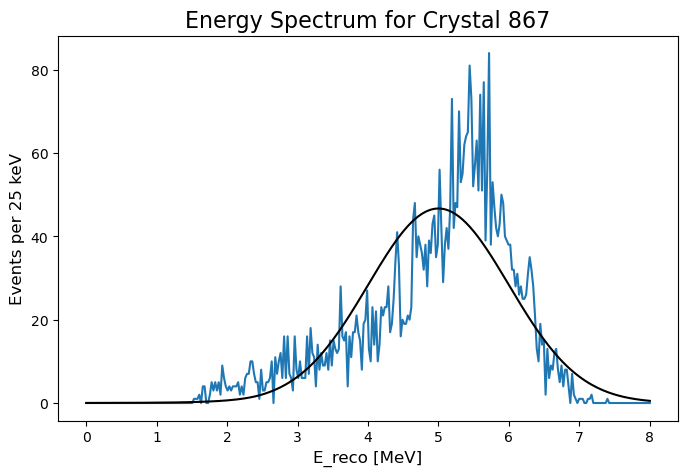

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(x_plot_binned, energy_binned)
plt.plot(x_plot_binned, y_plot_alldata_binned*scale_binned, color="black", label='Full Peak CB')


plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)

#### Create loss function, minimizer function and apply minimiser to loss function

In [11]:
nll = zfit.loss.UnbinnedNLL(model=alldata, data=energy_unbinned)

minimizer = zfit.minimize.Minuit()

result = minimizer.minimize(nll, params=[mu,sigma,alpha,ndeg])
param_hesse = result.hesse()
print(result.params)
# these values are no longer just the ones set at the limit-- the minimisation and loss function have applied some adjustments


name           value  (rounded)        hesse    at limit
-----------  ------------------  -----------  ----------
guess mean              5.48798  +/-    0.02       False
guess width             0.56784  +/-   0.014       False
alpha                  0.524438  +/-    0.02       False
ndeg                     79.999  +/-    0.26       False


#### Plot with minimized variables

Text(0.5, 0, 'E_reco [MeV]')

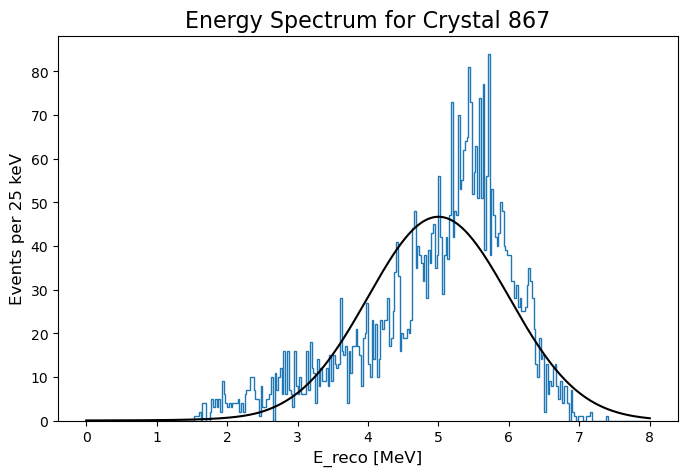

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
energy_binned, bin_location, patches = ax.hist(energy_unbinned,
                           bins=bin_count,histtype='step',
                           range=(0,8))
x_plot_binned = np.linspace(lower[-1][0], upper[0][-1], num=len(energy_binned))

y_plot_alldata_binned = zfit.run(alldata.pdf(x_plot_binned,norm_range=cryspec))

scale_binned = (np.sum(energy_binned)/bin_count)*x_range


plt.plot(x_plot, y_plot_alldata*scale, color="black", label='Full Peak CB')

plt.title("Energy Spectrum for Crystal 867", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)